Copyright (C) 2017 Leen De Baets (leen.debaets@ugent.be)

This file is part of PLAID code repo.

This program is free software: you can redistribute it and/or modify
it under the terms of the GNU General Public License as published by
the Free Software Foundation, either version 3 of the License, or
(at your option) any later version.

This program is distributed in the hope that it will be useful,
but WITHOUT ANY WARRANTY; without even the implied warranty of
MERCHANTABILITY or FITNESS FOR A PARTICULAR PURPOSE.  See the
GNU General Public License for more details.

You should have received a copy of the GNU General Public License
along with this program.  If not, see <http://www.gnu.org/licenses/>

This code is based on the code of Jingkun Goa that analyses the PLAID data. The original code can be found in the notebooks on plaidplug.com or http://nbviewer.jupyter.org/github/jingkungao/PLAID/blob/master/ParseData.ipynb

# Read the data

In [1]:
%matplotlib inline
import matplotlib

import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.font_manager as fm
from matplotlib import rc 
rc('font', family='Times New Roman') 

import subprocess
import numpy as np
from datetime import datetime

In [2]:
# functions to read data and meta data
def read_data_given_id(path,ids,progress=True,last_offset=0):
    '''read data given a list of ids and CSV paths'''
    start = datetime.now()
    n = len(ids)
    if n == 0:
        return {}
    else:
        data = {}
        for (i,ist_id) in enumerate(ids, start=1):
            if progress and np.mod(i,np.ceil(n/10))==0:
                print('%d/%d (%2.0f%s) have been read...\t time consumed: %ds'\
                      %(i,n,i/n*100,'%',(datetime.now()-start).seconds))
            if last_offset==0:
                data[ist_id] = np.genfromtxt(path+str(ist_id)+'.csv',delimiter=',',\
                                         names='current,voltage',dtype=(float,float))
            else:
                p=subprocess.Popen(['tail','-'+str(int(last_offset)),path+str(ist_id)+'.csv'],\
                                   stdout=subprocess.PIPE)
                data[ist_id] = np.genfromtxt(p.stdout,delimiter=',',names='current,voltage',\
                                 dtype=(float,float))
        print('%d/%d (%2.0f%s) have been read(Done!) \t time consumed: %ds'\
            %(n,n,100,'%',(datetime.now()-start).seconds))
        return data

def clean_meta(ist):
    '''remove None elements in Meta Data ''' 
    clean_ist = ist.copy()
    for k,v in ist.items():
        if len(v) == 0:
            del clean_ist[k]
    return clean_ist
                
def parse_meta(meta):
    '''parse meta data for easy access'''
    M = {}
    for m in meta:
        for app in m:
            M[int(app['id'])] = clean_meta(app['meta'])
    return M


In [3]:
# read meta
Data_path = '/home/guest/Dataset/PLAID/'
csv_path = Data_path + 'CSV/';

import json

with open(Data_path + 'meta1.json') as data_file:    
    meta1 = json.load(data_file)

#with open(Data_path + 'meta2.json') as data_file:
with open('meta2StatusesRenamed.json') as data_file:
    meta2 = json.load(data_file)
    
#Meta = parse_meta([meta1,meta2]) # consider PLAID1 and 2
#Meta = parse_meta([meta1])
Meta = parse_meta([meta2])

In [4]:
# read data
# applinace types of all instances
Types = [x['type'] for x in Meta.values()]
# unique appliance types
Unq_type = list(set(Types)) 
Unq_type.sort()
IDs_for_read_data = list(Meta.keys())
# households of appliances
Locs = [x['header']['collection_time']+'_'+x['location'] for x in Meta.values()]
# unique households
Unq_loc = list(set(Locs))
Unq_loc.sort()

print('Number of households: %d\nNumber of total measurements:%d'%(len(Unq_loc),len(Locs)))

Number of households: 9
Number of total measurements:719


In [5]:
npts = 10000
Data = read_data_given_id(csv_path,IDs_for_read_data,progress=True, last_offset=npts)

72/719 (10%) have been read...	 time consumed: 1s
144/719 (20%) have been read...	 time consumed: 3s
216/719 (30%) have been read...	 time consumed: 5s
288/719 (40%) have been read...	 time consumed: 7s
360/719 (50%) have been read...	 time consumed: 9s
432/719 (60%) have been read...	 time consumed: 11s
504/719 (70%) have been read...	 time consumed: 13s
576/719 (80%) have been read...	 time consumed: 15s
648/719 (90%) have been read...	 time consumed: 18s
719/719 (100%) have been read(Done!) 	 time consumed: 20s


In [6]:
type_Ids = {}
loc_Ids = {}
Mapping = {}
n = len(Data)
type_label = np.zeros(n,dtype='int')
loc_label = np.zeros(n,dtype='int')
for (ii,t) in enumerate(Unq_type):
    type_Ids[t] = [i-1 for i,j in enumerate(Types,start=1) if j == t]
    type_label[type_Ids[t]] = ii
    Mapping[ii] = t
for (ii,t) in enumerate(Unq_loc):
    loc_Ids[t] = [i-1 for i,j in enumerate(Locs,start=1) if j == t]
    loc_label[loc_Ids[t]] = ii+1
print('number of different types: %d'% len(Unq_type))
print('number of different households: %d'% len(Unq_loc))

number of different types: 11
number of different households: 9


In [7]:
Types = np.array(Types)

Statuses = [x['instances']['status'] for x in Meta.values()]
Statuses = np.array(Statuses)

Houses = [x['location'] for x in Meta.values()]
Houses = np.array(Houses)

Brands = [x['appliance']['brand'] for x in Meta.values()]
Brands = np.array(Brands)

data_ids = np.array(list(Data.keys()))

# Plot the different statuses

In [8]:
def show_different_statuses(appliance_name, Types, Statuses, Brands, Houses, data_ids):
    sum_different_instances = 0
    anount_instances = []
    amount_programs = []
    
    appliance_ids = np.where(Types == appliance_name)[0]
    appliance_statuses = Statuses[appliance_ids]
    appliance_houses = Houses[appliance_ids]
    appliance_data_ids = data_ids[appliance_ids]
    appliance_brands = Brands[appliance_ids]

    for i in np.unique(appliance_houses):
        ids = np.where(appliance_houses == i)[0]
        house_statuses = appliance_statuses[ids]
        house_data_ids = appliance_data_ids[ids]
        house_brands = appliance_brands[ids]
        
        
        for k in np.unique(house_brands):
            sum_different_instances += 1
            
            ids = np.where(house_brands == k)[0]
            house_brand_statuses = house_statuses[ids]
            house_brand_data_ids = house_data_ids[ids]
            
            index = 1
            plt.figure(figsize = (4*len(np.unique(house_brand_statuses)),3))
            amount_programs.append(len(np.unique(house_brand_statuses)))
            anount_instances.append(len(ids))
            for j in np.unique(house_brand_statuses):
                ids2 = np.where(house_brand_statuses == j)[0][0]
                house_data_ids2 = house_brand_data_ids[ids2]
                plt.subplot(1,len(np.unique(house_brand_statuses)),index)
                plt.plot(Data[house_data_ids2]['current'],Data[house_data_ids2]['voltage'])
                plt.yticks(fontsize=15)
                plt.xticks(fontsize=15)
                if index == 1:
                    plt.ylabel(i + "\n" + k, fontsize=30)
                plt.title(j ,fontsize = 20)
                index += 1

            plt.show()
    print(np.unique(house_statuses))
    print('Each instance is measure {} times, total of {}'.format(anount_instances,sum(anount_instances)))
    print('{}: {} instances, with {} programs'.format(appliance_name,sum_different_instances,np.unique(amount_programs)))

In [9]:
np.unique(Types)

array(['Air Conditioner', 'Compact Fluorescent Lamp', 'Fan', 'Fridge',
       'Hairdryer', 'Heater', 'Incandescent Light Bulb', 'Laptop',
       'Microwave', 'Vacuum', 'Washing Machine'], 
      dtype='<U24')

# Air conditioner

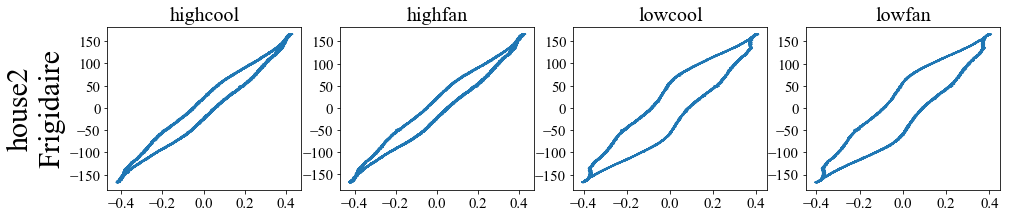

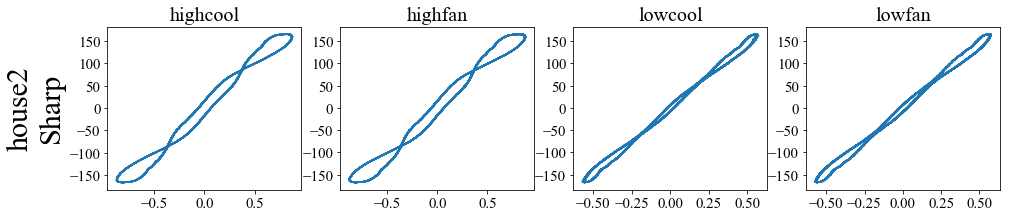

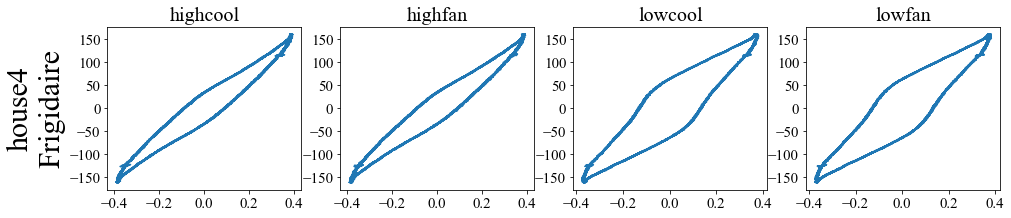

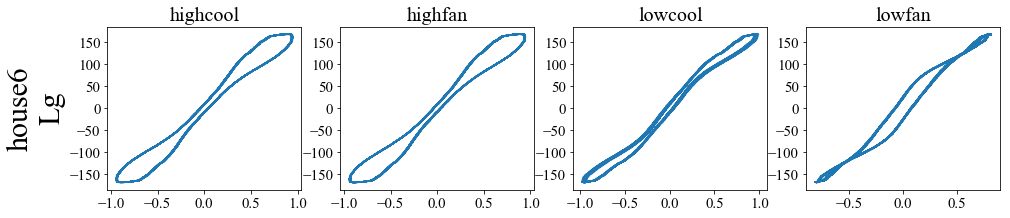

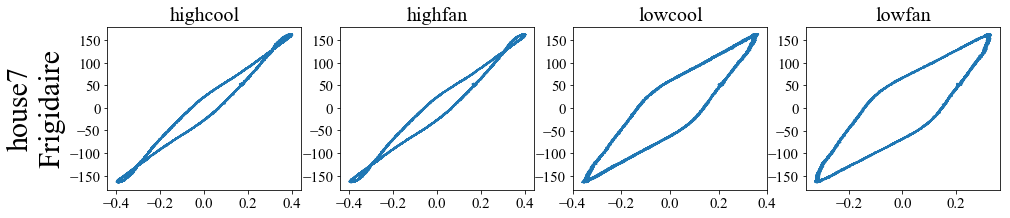

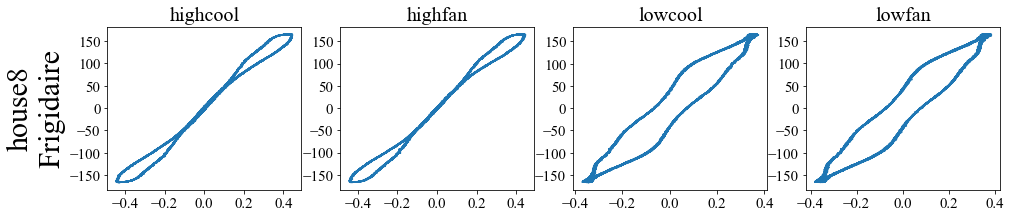

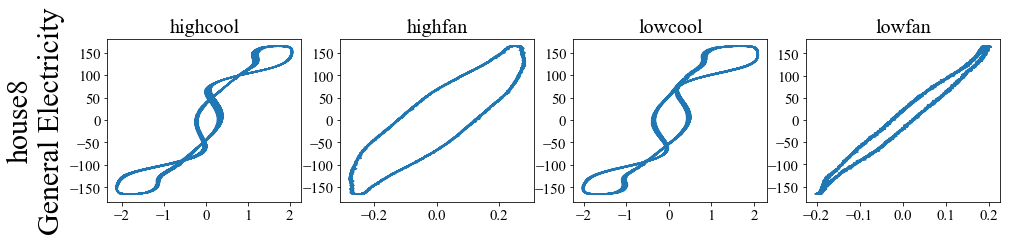

['highcool' 'highfan' 'lowcool' 'lowfan']
Each instance is measure [20, 20, 20, 19, 19, 20, 24] times, total of 142
Air Conditioner: 7 instances, with [4] programs


In [10]:
show_different_statuses('Air Conditioner', Types, Statuses, Brands, Houses, data_ids)

# Compact Fluorescent Lamp

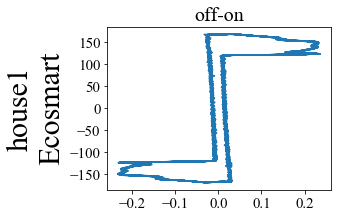

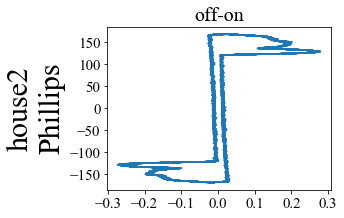

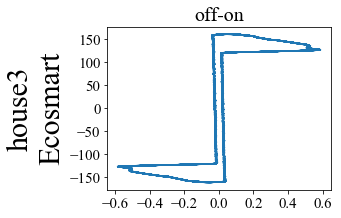

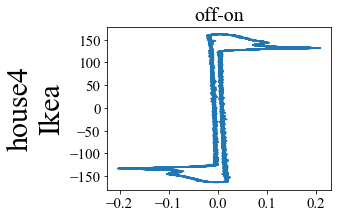

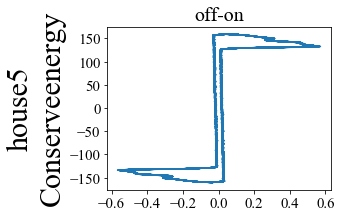

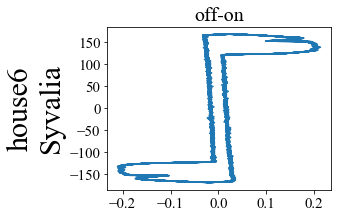

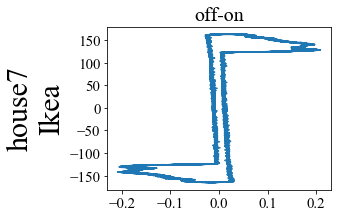

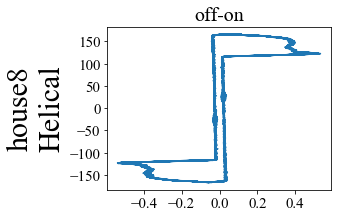

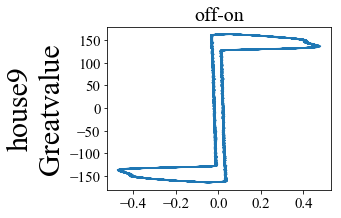

['off-on']
Each instance is measure [5, 5, 5, 5, 5, 5, 5, 5, 5] times, total of 45
Compact Fluorescent Lamp: 9 instances, with [1] programs


In [11]:
show_different_statuses('Compact Fluorescent Lamp', Types, Statuses, Brands, Houses, data_ids)

# Fan

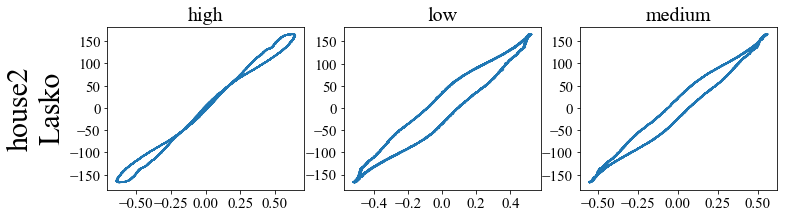

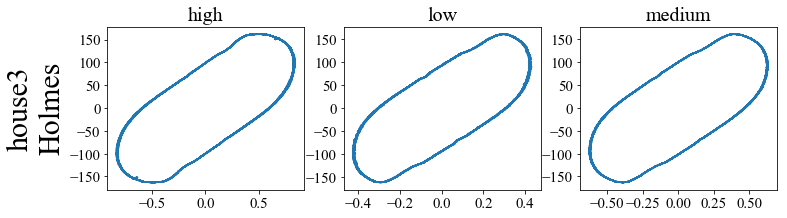

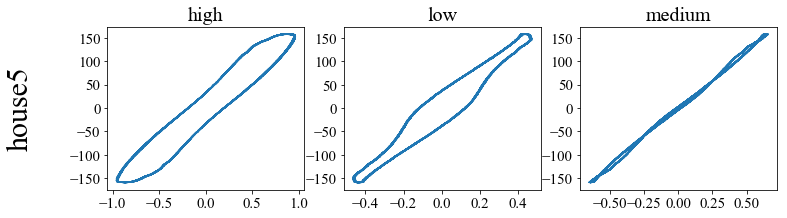

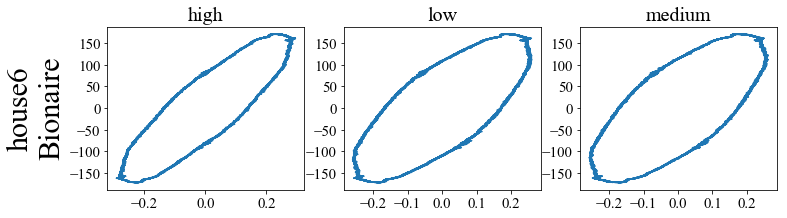

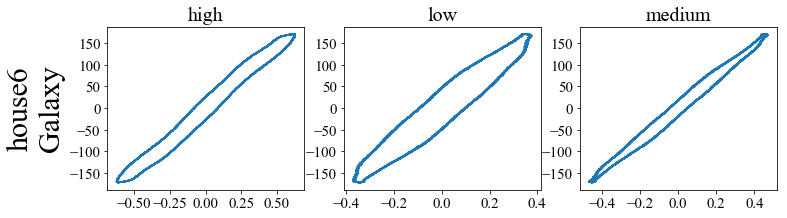

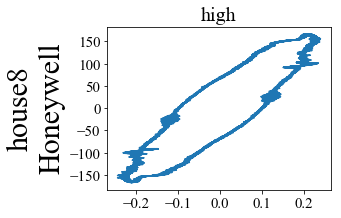

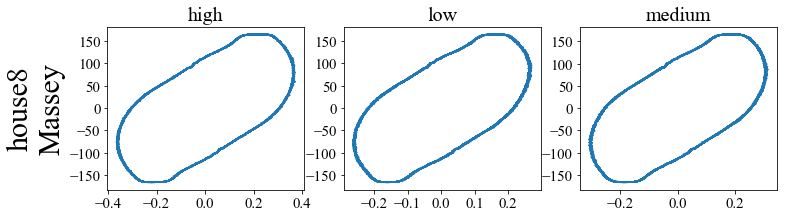

['high' 'low' 'medium']
Each instance is measure [15, 15, 15, 15, 15, 5, 15] times, total of 95
Fan: 7 instances, with [1 3] programs


In [12]:
show_different_statuses('Fan', Types, Statuses, Brands, Houses, data_ids)

# Fridge 

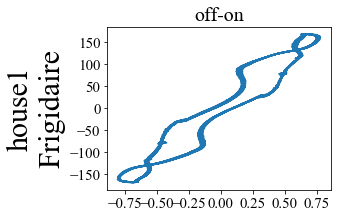

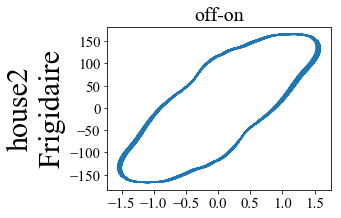

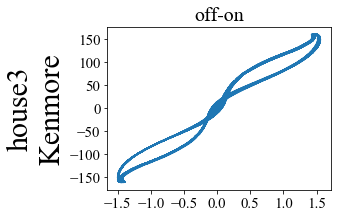

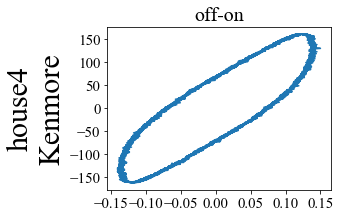

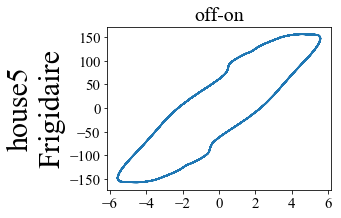

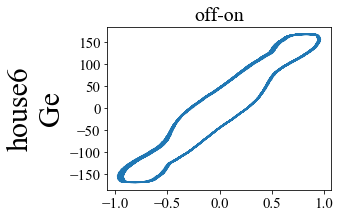

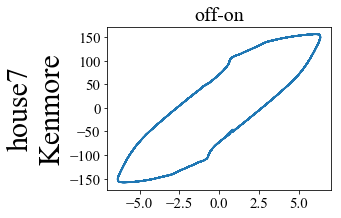

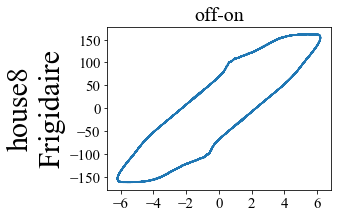

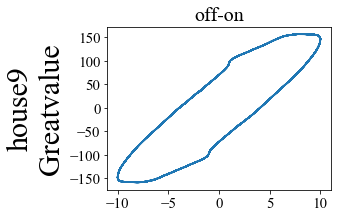

['off-on']
Each instance is measure [5, 5, 5, 5, 7, 5, 5, 10, 5] times, total of 52
Fridge: 9 instances, with [1] programs


In [13]:
show_different_statuses('Fridge', Types, Statuses, Brands, Houses, data_ids)

# Hairdryer

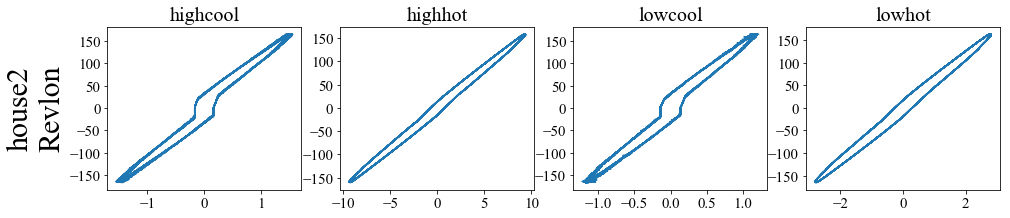

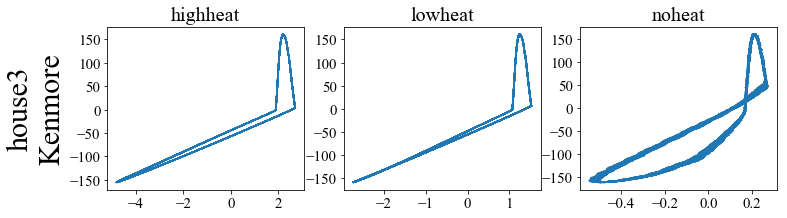

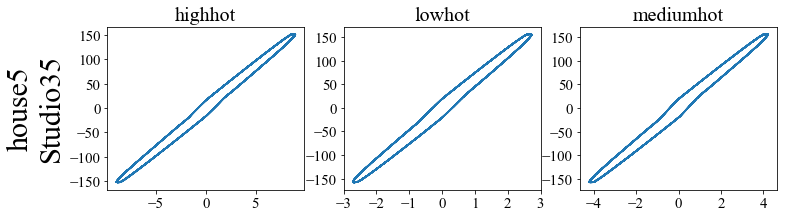

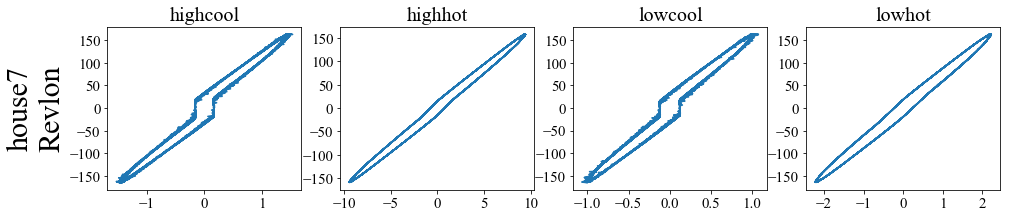

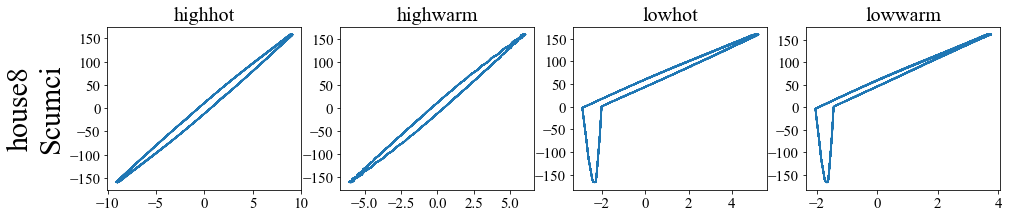

['highhot' 'highwarm' 'lowhot' 'lowwarm']
Each instance is measure [20, 17, 15, 20, 20] times, total of 92
Hairdryer: 5 instances, with [3 4] programs


In [14]:
show_different_statuses('Hairdryer', Types, Statuses, Brands, Houses, data_ids)

# Heater

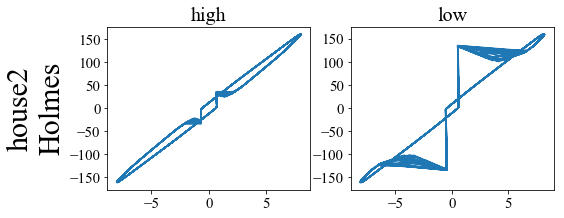

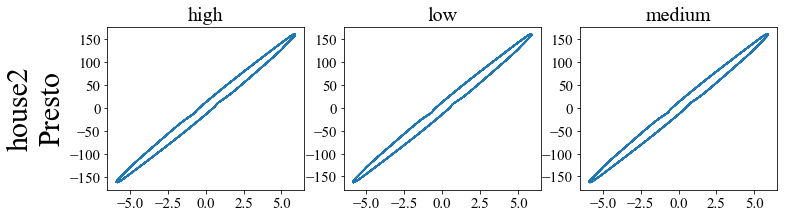

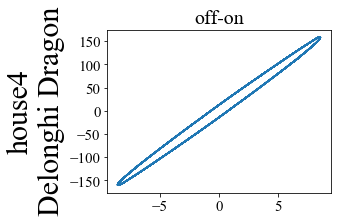

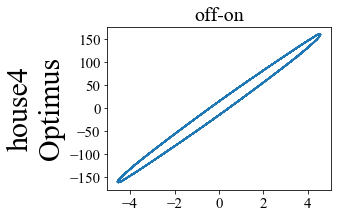

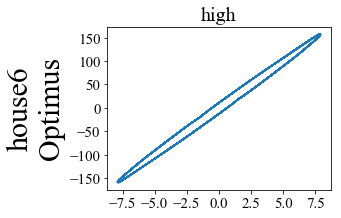

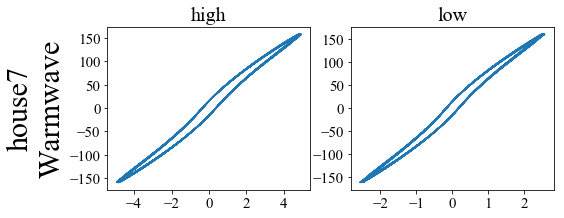

['high' 'low']
Each instance is measure [10, 15, 5, 5, 5, 10] times, total of 50
Heater: 6 instances, with [1 2 3] programs


In [15]:
show_different_statuses('Heater', Types, Statuses, Brands, Houses, data_ids)

# Incandescent Light Bulb

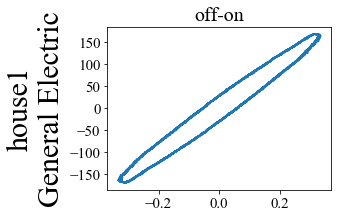

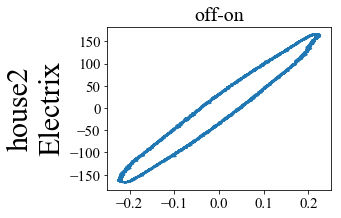

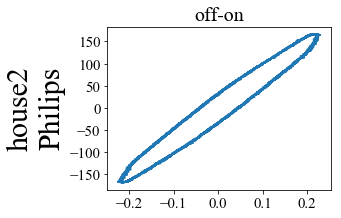

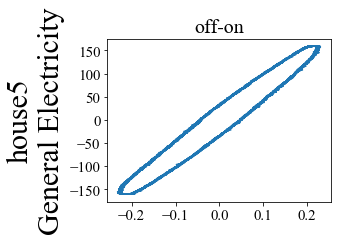

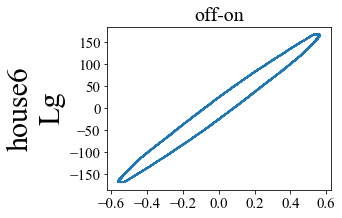

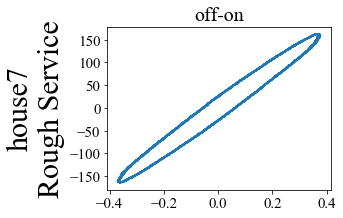

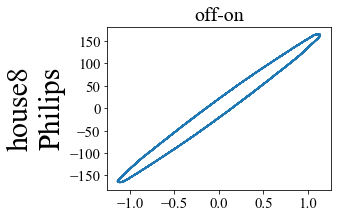

['off-on']
Each instance is measure [5, 5, 5, 5, 4, 5, 5] times, total of 34
Incandescent Light Bulb: 7 instances, with [1] programs


In [16]:
show_different_statuses('Incandescent Light Bulb', Types, Statuses, Brands, Houses, data_ids)

# Laptop

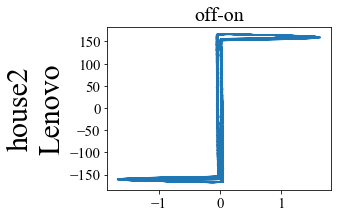

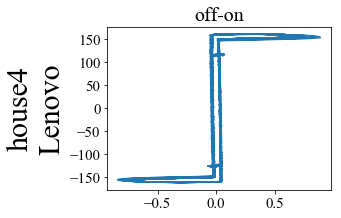

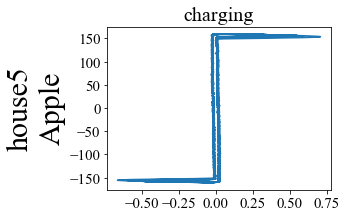

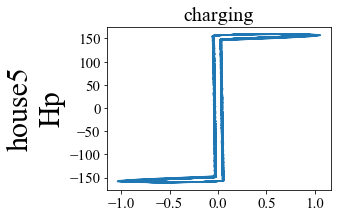

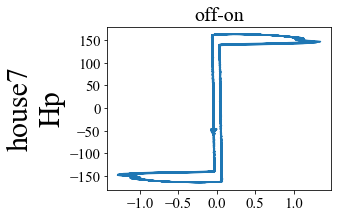

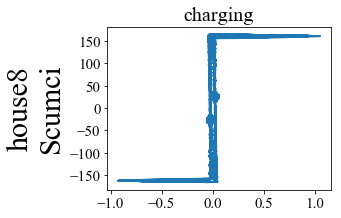

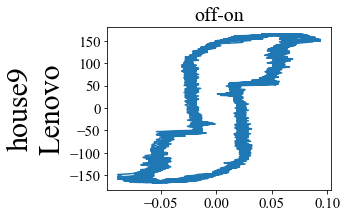

['off-on']
Each instance is measure [5, 5, 5, 5, 5, 5, 5] times, total of 35
Laptop: 7 instances, with [1] programs


In [17]:
show_different_statuses('Laptop', Types, Statuses, Brands, Houses, data_ids)

# Microwave

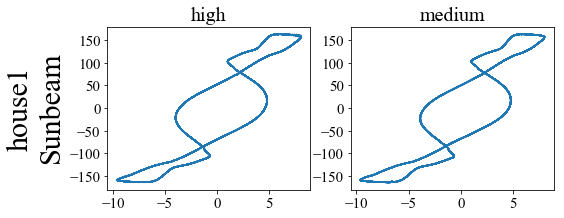

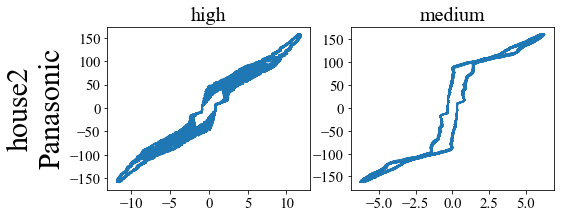

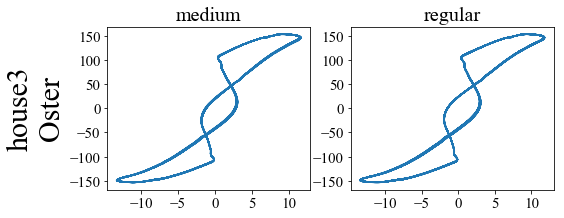

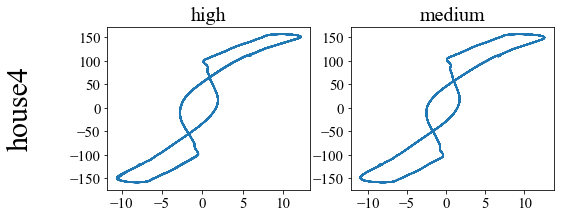

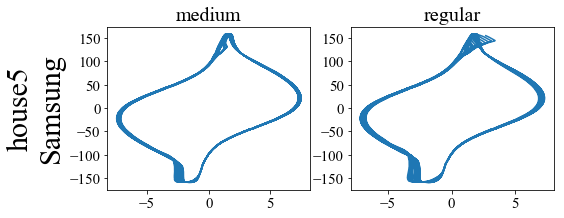

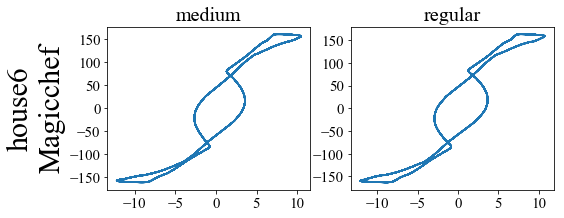

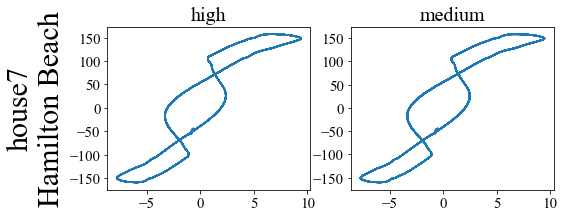

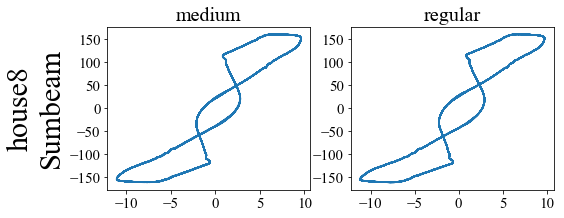

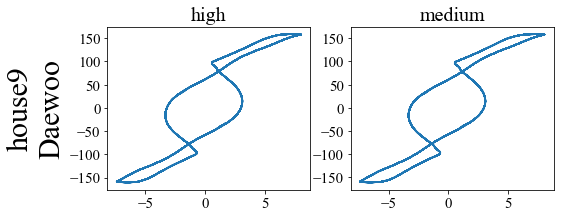

['high' 'medium']
Each instance is measure [10, 10, 10, 10, 10, 10, 10, 10, 10] times, total of 90
Microwave: 9 instances, with [2] programs


In [18]:
show_different_statuses('Microwave', Types, Statuses, Brands, Houses, data_ids)

# Vacuum

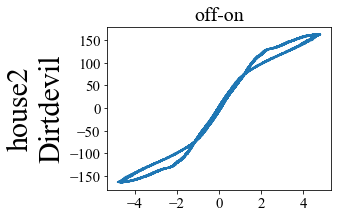

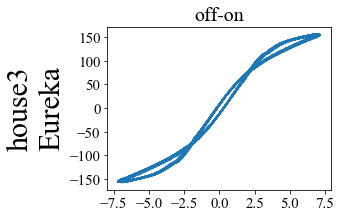

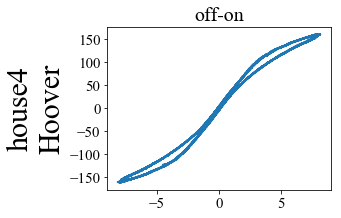

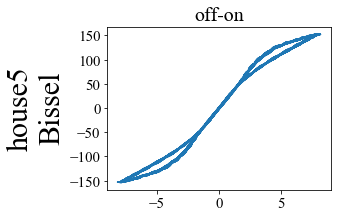

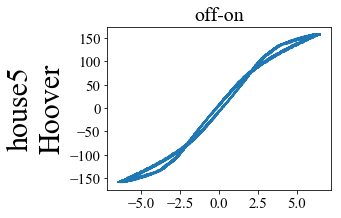

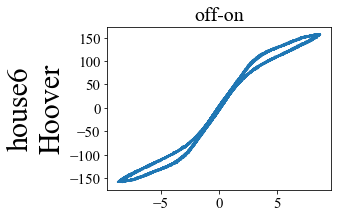

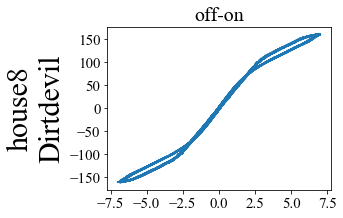

['off-on']
Each instance is measure [5, 5, 5, 5, 5, 5, 5] times, total of 35
Vacuum: 7 instances, with [1] programs


In [19]:
show_different_statuses('Vacuum', Types, Statuses, Brands, Houses, data_ids)

# Washing Machine

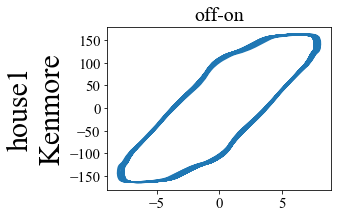

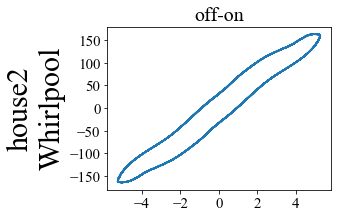

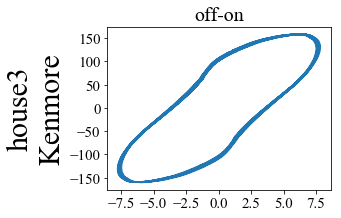

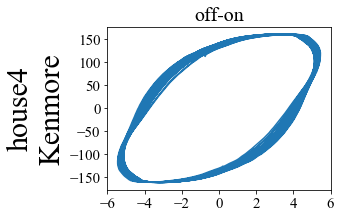

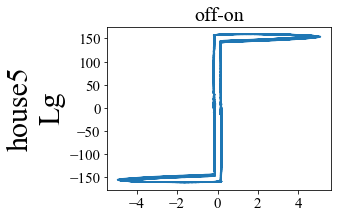

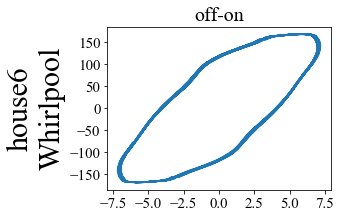

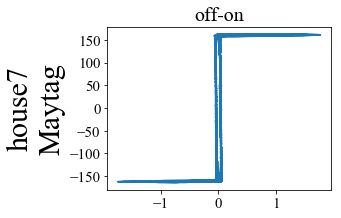

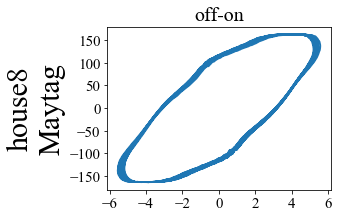

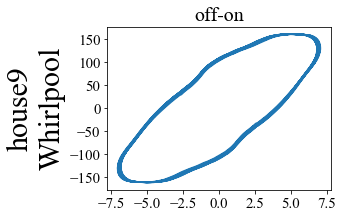

['off-on']
Each instance is measure [5, 9, 5, 5, 5, 5, 5, 5, 5] times, total of 49
Washing Machine: 9 instances, with [1] programs


In [20]:
show_different_statuses('Washing Machine', Types, Statuses, Brands, Houses, data_ids)